In [1]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly # Plotly is a pre-requisite before installing cufflinks

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'



In [4]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import pandas_profiling 
import numpy as np
from pylab import *
from scipy.stats import norm
from scipy.stats import expon
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
%matplotlib inline

#Otro estilo de graficas
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from IPython.display import display,HTML
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

#Para el mapa de colores
import plotly.graph_objects as go

import random

**Objetivo**

El objetivo de este notebook es estudiar la correlacion (si la hay) entre las emisiones de CO2 y la esperanza de vida al nacer a partir de datos obtenidos del banco mundial en su dataset 'World development indicators'. Lo que esperamos encontrar es una correlacion negativa, es decir que a mayores cantidades de CO2 la esperanza de vida baje.

**Cargar los datos**

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
df_indicators = pd.read_csv ('Indicators.csv')

In [8]:
df_indicators.head()

CountryName CountryCode                                      IndicatorName  \
0  Arab World         ARB  Adolescent fertility rate (births per 1,000 wo...   
1  Arab World         ARB  Age dependency ratio (% of working-age populat...   
2  Arab World         ARB  Age dependency ratio, old (% of working-age po...   
3  Arab World         ARB  Age dependency ratio, young (% of working-age ...   
4  Arab World         ARB        Arms exports (SIPRI trend indicator values)   

    IndicatorCode  Year         Value  
0     SP.ADO.TFRT  1960  1.335609e+02  
1     SP.POP.DPND  1960  8.779760e+01  
2  SP.POP.DPND.OL  1960  6.634579e+00  
3  SP.POP.DPND.YG  1960  8.102333e+01  
4  MS.MIL.XPRT.KD  1960  3.000000e+06

In [9]:
df_indicators.shape

(5656458, 6)

# Data understanding y data preparation

Es un dataframe muy grande, tiene más de 5 millones de filas. Veamos que países incluye:

In [10]:
df_indicators['CountryName'].unique()

array(['Arab World', 'Caribbean small states',
       'Central Europe and the Baltics',
       'East Asia & Pacific (all income levels)',
       'East Asia & Pacific (developing only)', 'Euro area',
       'Europe & Central Asia (all income levels)',
       'Europe & Central Asia (developing only)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'High income: nonOECD', 'High income: OECD',
       'Latin America & Caribbean (all income levels)',
       'Latin America & Caribbean (developing only)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa (all income levels)',
       'Middle East & North Africa (developing only)', 'Middle income',
       'North America', 'OECD members', 'Other small states',
       'Pacific island small states', 'Small states', 'South Asia',
       'Sub-Saharan Afr

No todos son países, algunos son continentes o islas, por eso hay que eliminar todo lo que no sea un país. Para eso tenemos la lista notcountries con todos los elementos que no son países:

In [11]:
notcountries = ['Arab World', 'Caribbean small states', 'Central Europe and the Baltics',
 'East Asia & Pacific (all income levels)',
 'East Asia & Pacific (developing only)', 'Euro area',
 'Europe & Central Asia (all income levels)',
 'Europe & Central Asia (developing only)', 'European Union',
 'Fragile and conflict affected situations',
 'Heavily indebted poor countries (HIPC)', 'High income',
 'High income: nonOECD', 'High income: OECD',
 'Latin America & Caribbean (all income levels)',
 'Latin America & Caribbean (developing only)',
 'Least developed countries: UN classification', 'Low & middle income',
 'Low income', 'Lower middle income',
 'Middle East & North Africa (all income levels)',
 'Middle East & North Africa (developing only)', 'Middle income',
 'North America' 'OECD members' ,'Other small states',
 'Pacific island small states', 'Small states', 'South Asia',
 'Sub-Saharan Africa (all income levels)',
 'Sub-Saharan Africa (developing only)' ,'Upper middle income' ,'World', 
 'North America', 'OECD members','American Samoa','Aruba','Bermuda','Cayman Islands',
 'Channel Islands','Curacao','Faeroe Islands','French Polynesia','Greenland','Guam',
 'Hong Kong SAR, China','Isle of Man','Kosovo','Macao SAR, China','New Caledonia',
 'Northern Mariana Islands','Puerto Rico','Sint Maarten (Dutch part)','St. Martin (French part)',
 'Swaziland','Timor-Leste','Turks and Caicos Islands','Virgin Islands (U.S.)','West Bank and Gaza']
notcountries = set(notcountries)

Ahora creamos el dataframe df_paises que es el df_indicators sin los notcountries

In [12]:
df_paises=df_indicators[df_indicators['CountryName'].apply(lambda x: x not in notcountries)]

In [13]:
df_paises.head()

CountryName CountryCode  \
3492  Afghanistan         AFG   
3493  Afghanistan         AFG   
3494  Afghanistan         AFG   
3495  Afghanistan         AFG   
3496  Afghanistan         AFG   

                                          IndicatorName   IndicatorCode  Year  \
3492  Adolescent fertility rate (births per 1,000 wo...     SP.ADO.TFRT  1960   
3493  Age dependency ratio (% of working-age populat...     SP.POP.DPND  1960   
3494  Age dependency ratio, old (% of working-age po...  SP.POP.DPND.OL  1960   
3495  Age dependency ratio, young (% of working-age ...  SP.POP.DPND.YG  1960   
3496        Arms imports (SIPRI trend indicator values)  MS.MIL.MPRT.KD  1960   

             Value  
3492  1.453210e+02  
3493  8.171773e+01  
3494  5.086254e+00  
3495  7.663147e+01  
3496  4.000000e+07

Ahora el df_paises sólo contiene indicadores de países y no de regiones

In [14]:
len(df_paises['IndicatorName'].unique())

1344

Tenemos muchos indicadores (1344), por eso necesitamos sacar todos los que no vamos a usar más adelante.

In [15]:
df_paises['IndicatorName']

3492       Adolescent fertility rate (births per 1,000 wo...
3493       Age dependency ratio (% of working-age populat...
3494       Age dependency ratio, old (% of working-age po...
3495       Age dependency ratio, young (% of working-age ...
3496             Arms imports (SIPRI trend indicator values)
3497                    Birth rate, crude (per 1,000 people)
3498                                      CO2 emissions (kt)
3499                  CO2 emissions (metric tons per capita)
3500       CO2 emissions from gaseous fuel consumption (%...
3501        CO2 emissions from gaseous fuel consumption (kt)
3502       CO2 emissions from liquid fuel consumption (% ...
3503         CO2 emissions from liquid fuel consumption (kt)
3504       CO2 emissions from solid fuel consumption (% o...
3505          CO2 emissions from solid fuel consumption (kt)
3506                    Death rate, crude (per 1,000 people)
3507         DEC alternative conversion factor (LCU per US$)
3508                Expo

El formato en el que está la tabla no me sirve para visualizar, necesito poner los indicadores en las columnas. Uso la función pivot_table:

In [16]:
df_paises = pd.pivot_table(df_paises,index=['CountryName','Year','CountryCode'],columns='IndicatorName',values='Value',aggfunc=sum).reset_index()

In [17]:
df_paises

IndicatorName  CountryName  Year CountryCode  \
0              Afghanistan  1960         AFG   
1              Afghanistan  1961         AFG   
2              Afghanistan  1962         AFG   
3              Afghanistan  1963         AFG   
4              Afghanistan  1964         AFG   
5              Afghanistan  1965         AFG   
6              Afghanistan  1966         AFG   
7              Afghanistan  1967         AFG   
8              Afghanistan  1968         AFG   
9              Afghanistan  1969         AFG   
10             Afghanistan  1970         AFG   
11             Afghanistan  1971         AFG   
12             Afghanistan  1972         AFG   
13             Afghanistan  1973         AFG   
14             Afghanistan  1974         AFG   
15             Afghanistan  1975         AFG   
16             Afghanistan  1976         AFG   
17             Afghanistan  1977         AFG   
18             Afghanistan  1978         AFG   
19             Afghanistan  1979         AFG   
20             Afghanistan  1980         AFG   
21             Afghanistan  1981         AFG   
22             Afghanistan  1982         AFG   
23             Afghanistan  1983         AFG   
24             Afghanistan  1984         AFG   
25             Afghanistan  1985         AFG   
26             Afghanistan  1986         AFG   
27             Afghanistan  1987         AFG   
28             Afghanistan  1988         AFG   
29             Afghanistan  1989         AFG   
...                    ...   ...         ...   
10610             Zimbabwe  1986         ZWE   
10611             Zimbabwe  1987         ZWE   
10612             Zimbabwe  1988         ZWE   
10613             Zimbabwe  1989         ZWE   
10614             Zimbabwe  1990         ZWE   
10615             Zimbabwe  1991         ZWE   
10616             Zimbabwe  1992         ZWE   
10617             Zimbabwe  1993         ZWE   
10618             Zimbabwe  1994         ZWE   
10619             Zimbabwe  1995         ZWE   
10620             Zimbabwe  1996         ZWE   
10621             Zimbabwe  1997         ZWE   
10622             Zimbabwe  1998         ZWE   
10623             Zimbabwe  1999         ZWE   
10624             Zimbabwe  2000         ZWE   
10625             Zimbabwe  2001         ZWE   
10626             Zimbabwe  2002         ZWE   
10627             Zimbabwe  2003         ZWE   
10628             Zimbabwe  2004         ZWE   
10629             Zimbabwe  2005         ZWE   
10630             Zimbabwe  2006         ZWE   
10631             Zimbabwe  2007         ZWE   
10632             Zimbabwe  2008         ZWE   
10633             Zimbabwe  2009         ZWE   
10634             Zimbabwe  2010         ZWE   
10635             Zimbabwe  2011         ZWE   
10636             Zimbabwe  2012         ZWE   
10637             Zimbabwe  2013         ZWE   
10638             Zimbabwe  2014         ZWE   
10639             Zimbabwe  2015         ZWE   

IndicatorName  2005 PPP conversion factor, GDP (LCU per international $)  \
0                                                            NaN           
1                                                            NaN           
2                                                            NaN           
3                                                            NaN           
4                                                            NaN           
5                                                            NaN           
6                                                            NaN           
7                                                            NaN           
8                                                            NaN           
9                                                            NaN           
10                                                           NaN           
11                                                           NaN           
12                                 

df_paises ahora tiene en las columnas los índices, por eso puedo estudiar mejor los datos.

Ya que tengo demasiados indicadores, me voy a quedar sólo con los que quiero estudiar, que son los que tienen CO2 y los que tienen Life expectancy.

In [18]:
indicadores=['CountryName','Year','CountryCode','CO2 emissions (kt)','CO2 emissions (metric tons per capita)','Life expectancy at birth, total (years)']

In [19]:
importantdata=df_paises[df_paises.columns.intersection(indicadores)]

El dataframe importantdata tiene sólo las columnas que aparecen en la lista 'indicadores'.

In [20]:
cleandata=importantdata.dropna()

In [21]:
cleandata.shape

(8277, 6)

In [25]:
cleandata

IndicatorName  CountryName  Year CountryCode  CO2 emissions (kt)  \
0              Afghanistan  1960         AFG             414.371   
1              Afghanistan  1961         AFG             491.378   
2              Afghanistan  1962         AFG             689.396   
3              Afghanistan  1963         AFG             707.731   
4              Afghanistan  1964         AFG             839.743   
5              Afghanistan  1965         AFG            1008.425   
6              Afghanistan  1966         AFG            1092.766   
7              Afghanistan  1967         AFG            1283.450   
8              Afghanistan  1968         AFG            1224.778   
9              Afghanistan  1969         AFG             942.419   
10             Afghanistan  1970         AFG            1672.152   
11             Afghanistan  1971         AFG            1895.839   
12             Afghanistan  1972         AFG            1532.806   
13             Afghanistan  1973         AFG            1639.149   
14             Afghanistan  1974         AFG            1917.841   
15             Afghanistan  1975         AFG            2126.860   
16             Afghanistan  1976         AFG            1987.514   
17             Afghanistan  1977         AFG            2390.884   
18             Afghanistan  1978         AFG            2159.863   
19             Afghanistan  1979         AFG            2240.537   
20             Afghanistan  1980         AFG            1760.160   
21             Afghanistan  1981         AFG            1983.847   
22             Afghanistan  1982         AFG            2101.191   
23             Afghanistan  1983         AFG            2522.896   
24             Afghanistan  1984         AFG            2830.924   
25             Afghanistan  1985         AFG            3509.319   
26             Afghanistan  1986         AFG            3142.619   
27             Afghanistan  1987         AFG            3124.284   
28             Afghanistan  1988         AFG            2867.594   
29             Afghanistan  1989         AFG            2775.919   
...                    ...   ...         ...                 ...   
10606             Zimbabwe  1982         ZWE            8811.801   
10607             Zimbabwe  1983         ZWE           10461.951   
10608             Zimbabwe  1984         ZWE            9922.902   
10609             Zimbabwe  1985         ZWE           10263.933   
10610             Zimbabwe  1986         ZWE           13127.860   
10611             Zimbabwe  1987         ZWE           15240.052   
10612             Zimbabwe  1988         ZWE           16101.797   
10613             Zimbabwe  1989         ZWE           16186.138   
10614             Zimbabwe  1990         ZWE           15504.076   
10615             Zimbabwe  1991         ZWE           15823.105   
10616             Zimbabwe  1992         ZWE           16901.203   
10617             Zimbabwe  1993         ZWE           16208.140   
10618             Zimbabwe  1994         ZWE           17645.604   
10619             Zimbabwe  1995         ZWE           15130.042   
10620             Zimbabwe  1996         ZWE           14994.363   
10621             Zimbabwe  1997         ZWE           14407.643   
10622             Zimbabwe  1998         ZWE           14253.629   
10623             Zimbabwe  1999         ZWE           15834.106   
10624             Zimbabwe  2000         ZWE           13886.929   
10625             Zimbabwe  2001         ZWE           12563.142   
10626             Zimbabwe  2002         ZWE           11932.418   
10627             Zimbabwe  2003         ZWE           10626.966   
10628             Zimbabwe  2004         ZWE            9864.230   
10629             Zimbabwe  2005         ZWE           10714.974   
10630             Zimbabwe  2006         ZWE           10249.265   
10631             Zimbabwe  2007         ZWE            9732.218   
10632             Zimbabwe  2008         ZWE            

**Ahora empezamos a estudiar los datos**

El primer objetivo de este notebook es estudiar si hay una correlación entre las emisiones de CO2 de los países y su esperanza de vida. Lo esperable es que si existe una correlación sea negativa, es decir cuánto más CO2, menos esperanza de vida.

In [22]:
pandas_profiling.ProfileReport(cleandata)


A partir de este data profiling inicial, ya podemos ver que la correlación negativa que estábamos buscando no sea tan directa. Es más, en el gráfico de correlaciones todas las correlaciones halladas son positivas.

Sin embargo, hay que entender que las correlaciones en este caso no implican causalidad, ya que por ejemplo la esperanza de vida a través de los años ha subido por factores como avances en la tecnología, en la salud, en la calidad de vida de las personas, etc. no porque haya más emisiones de CO2.

In [23]:
def de_mean(x):
    xmean = mean(x)
    return [xi - xmean for xi in x]

def covariance(x, y):
    n = len(x)
    return dot(de_mean(x), de_mean(y)) / (n-1)

def correlation(x, y):
    stddevx = x.std()
    stddevy = y.std()
    return covariance(x,y) / stddevx / stddevy  

In [24]:
corr=correlation(cleandata['CO2 emissions (metric tons per capita)'],cleandata['Life expectancy at birth, total (years)'])
corr

0.4038117985934955

Se observa que efectivamente la correlación que se observa a partir del dataframe es de 0.4.

Text(0.5, 0, 'Emisiones de CO2 (toneladas métricas per cápita)')

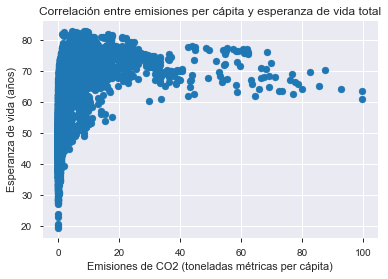

In [25]:
scatter(cleandata['CO2 emissions (metric tons per capita)'], cleandata['Life expectancy at birth, total (years)'])

plt.title("Correlación entre emisiones per cápita y esperanza de vida total")
plt.ylabel("Esperanza de vida (años)")
plt.xlabel("Emisiones de CO2 (toneladas métricas per cápita)")

Text(0.5, 0, 'Emisiones de CO2 (kt)')

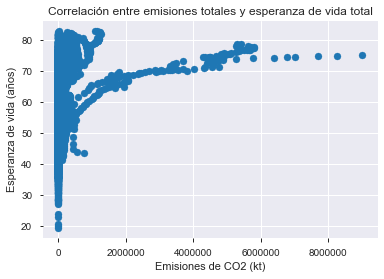

In [26]:
scatter(cleandata['CO2 emissions (kt)'], cleandata['Life expectancy at birth, total (years)'])

plt.title("Correlación entre emisiones totales y esperanza de vida total")
plt.ylabel("Esperanza de vida (años)")
plt.xlabel("Emisiones de CO2 (kt)")

No parece existir una correlación evidente y mucho menos lineal, sigamos estudiando los datos.

**Veamos como evolucionaron las emisiones de CO2 mundiales a través de los años:**

Text(0.5, 0, 'Años')

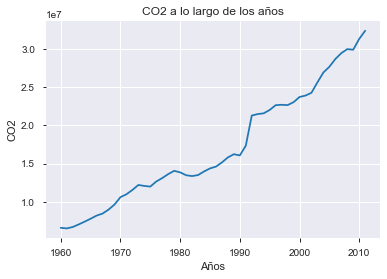

In [27]:
Emissions = cleandata.groupby('Year')['CO2 emissions (kt)'] .sum()

plt.plot(Emissions)
plt.title("CO2 a lo largo de los años")
plt.ylabel("CO2")
plt.xlabel("Años")

Se puede observar que hay un 'Salto' de los datos poco después de 1990. Esto no se debe a un aumento a las emisiones sino que es porque hay países que no tenían datos registrados hasta ese año

**Esperanza de vida a traves de los años**

Text(0.5, 0, 'Años')

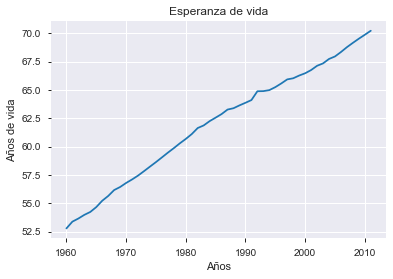

In [28]:
Esperanza = cleandata.groupby('Year')['Life expectancy at birth, total (years)'].mean()

plt.plot(Esperanza)
plt.title("Esperanza de vida")
plt.ylabel("Años de vida")
plt.xlabel("Años")

**¿Quiénes son los países que más emiten hoy en día?**

In [29]:
hoyendia=cleandata[cleandata['Year'].apply(lambda x: x==2011)]

In [30]:
hoyendia=hoyendia.sort_values(by=['CO2 emissions (kt)'])

C:\Users\Agus\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

Unrecognized location 'left center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



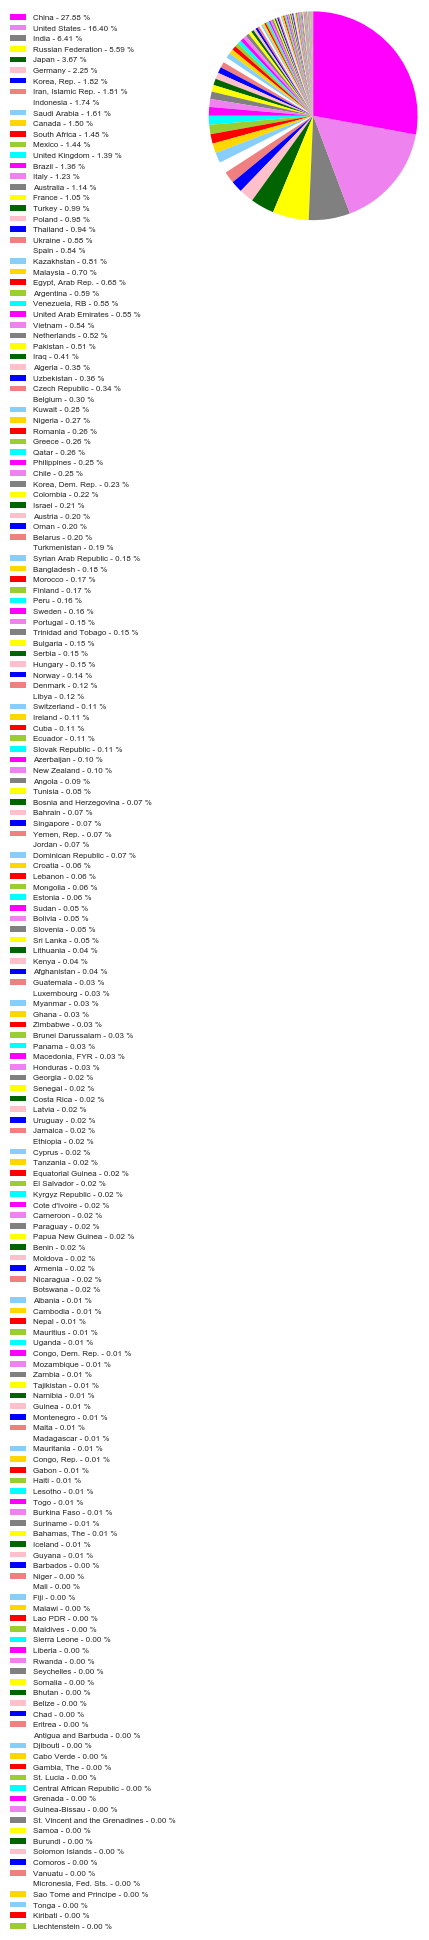

In [31]:
x = hoyendia['CountryName']
y = hoyendia['CO2 emissions (kt)']
colors = ['yellowgreen','red','gold','lightskyblue','white','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')

Claramente hay unos pocos países que son responsables significativos a nivel mundial, el resto casi no aporta. China, Estados Unidos e India son responsables de un 50%. Además, hay muchos países que son despreciables. Lo mismo se puede observar en el siguiente mapa:

In [34]:
indicadoresmap=['CountryName','CountryCode','Year','CO2 emissions (kt)','Life expectancy at birth, total (years)']
mapdata=df_paises[df_paises.columns.intersection(indicadores)]

In [35]:
mapdata=mapdata[mapdata['Year'].apply(lambda x: x==2011)]
mapdata=mapdata.dropna()

In [36]:
fig = go.Figure(data=go.Choropleth(
    locations = mapdata['CountryCode'],
    z = mapdata['CO2 emissions (kt)'],
    text = mapdata['CountryName'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'CO2 emissions<br>kt',
))

fig.update_layout(
    title_text='Global CO2 emissions (2011)',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: World Bank World Development Indicators',
        showarrow = False
    )]
)

fig.show()

Claramente se nota que China y Estados Unidos son los dos países con mayores emisiones por lejos, seguidos por India y Rusia. Veamos que sucede con la esperanza de vida:

In [35]:
fig = go.Figure(data=go.Choropleth(
    locations = mapdata['CountryCode'],
    z = mapdata['Life expectancy at birth, total (years)'],
    text = mapdata['CountryName'],
    colorscale = 'Greens',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'Esperanza de vida<br>',
))

fig.update_layout(
    title_text='Global life expectancy at birth (2011)',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: World Bank World Development Indicators',
        showarrow = False
    )]
)

fig.show()

En este caso se ve que los países que tienen mayor esperanza de vida son los de mayor desarrollo, en especial Europa. Se ve claramente que en África si bien no hay datos de algunos países, la esperanza de vida en promedio es menor que en el resto del mundo.

Estudiemos un poco la evolución de los 10 países que más emiten hoy en día:

In [36]:
hoyendia.sort_values(by='CO2 emissions (kt)').tail(10)

IndicatorName         CountryName  Year CountryCode  CO2 emissions (kt)  \
8171                 Saudi Arabia  2011         SAU          520277.627   
4307                    Indonesia  2011         IDN          563984.600   
4363           Iran, Islamic Rep.  2011         IRN          586598.989   
5035                  Korea, Rep.  2011         KOR          589426.246   
3579                      Germany  2011         DEU          729457.975   
4699                        Japan  2011         JPN         1187656.959   
7891           Russian Federation  2011         RUS         1808073.022   
4251                        India  2011         IND         2074344.893   
10187               United States  2011         USA         5305569.614   
2011                        China  2011         CHN         9019518.215   

IndicatorName  CO2 emissions (metric tons per capita)  \
8171                                        18.072451   
4307                                         2.303781   
4363                                         7.802145   
5035                                        11.840757   
3579                                         8.917833   
4699                                         9.291834   
7891                                        12.647328   
4251                                         1.662873   
10187                                       17.020216   
2011                                         6.710302   

IndicatorName  Life expectancy at birth, total (years)  
8171                                         73.854854  
4307                                         68.334390  
4363                                         74.412585  
5035                                         80.967073  
3579                                         80.741463  
4699                                         82.591220  
7891                                         69.658537  
4251                                         66.904171  
10187                                        78.641463  
2011                                         75.042000

In [37]:
top10peores=hoyendia[-10:].CountryName.unique() 

In [38]:
df_10peores=cleandata[cleandata['CountryName'].apply(lambda x: x in top10peores)]

In [39]:
df_10peores2011=df_10peores[df_10peores['Year'].apply(lambda x: x==2011)].sort_values(by='CO2 emissions (kt)')

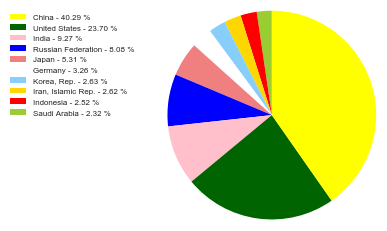

In [40]:
x = df_10peores2011['CountryName']
y = df_10peores2011['CO2 emissions (kt)']
colors = ['yellowgreen','red','gold','lightskyblue','white','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
porcent = 100*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')

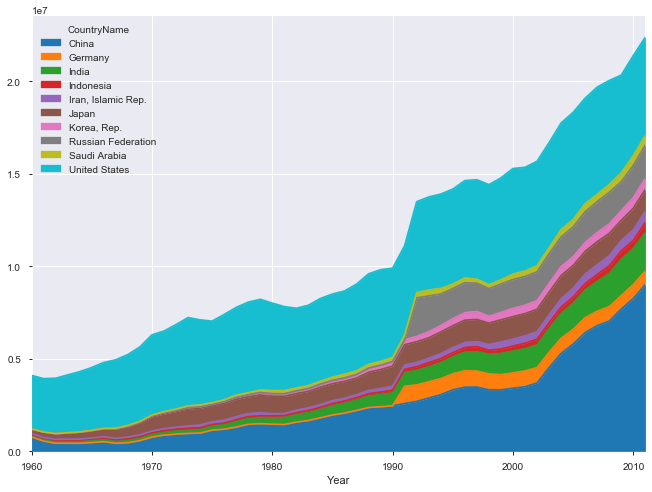

In [41]:
df2 = df_10peores.groupby(['Year', 'CountryName'])['CO2 emissions (kt)'].sum().unstack('CountryName').fillna(0)
df2.plot(kind='area', stacked=True, legend=True,figsize=(11,8))

Claramente Alemania y Rusia aparecen a partir del 1990 porque antes no había datos, por lo tanto distorsionan el gráfico. Si se ve el gráfico a partir del 1992 se vería así:

In [42]:
df_10peores2 =df_10peores[df_10peores['Year'].apply(lambda x: x > 1991)]

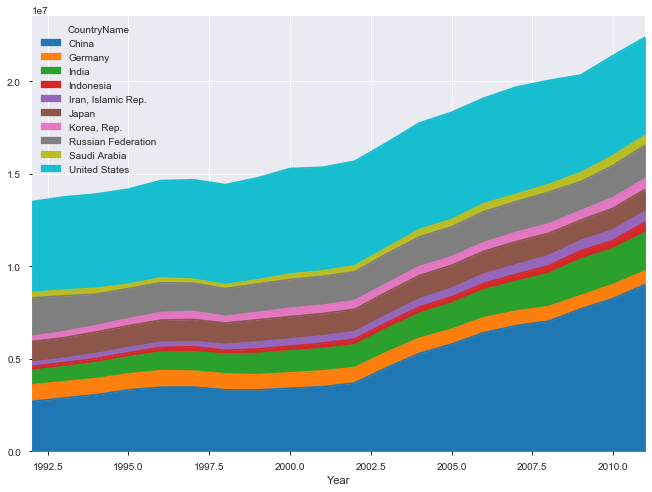

In [43]:
dfx = df_10peores2.groupby(['Year', 'CountryName'])['CO2 emissions (kt)'].sum().unstack('CountryName').fillna(0)
dfx.plot(kind='area', stacked=True, legend=True, figsize=(11,8))

Y si decidimos sacar a Alemania y Rusia se vería así:

In [44]:
df_10peores3 = df_10peores[df_10peores['CountryName'].apply(lambda x: x not in ('Germany', 'Russian Federation'))]

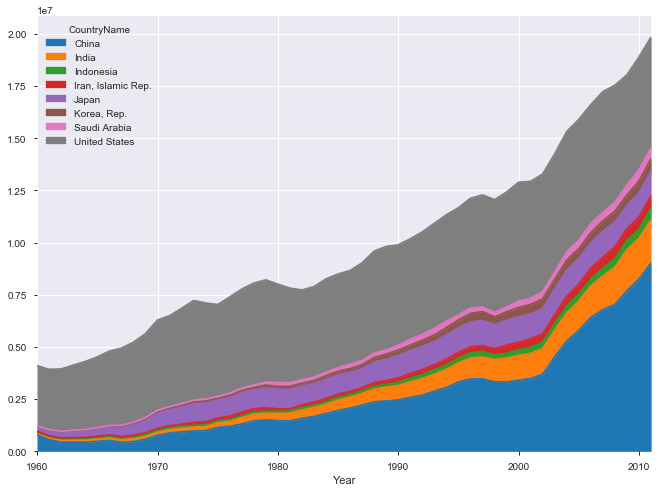

In [45]:
dfx = df_10peores3.groupby(['Year', 'CountryName'])['CO2 emissions (kt)'].sum().unstack('CountryName').fillna(0)
dfx.plot(kind='area', stacked=True, legend=True,figsize=(11,8))

Lo mismo pasa con la esperanza de vida, claramente se nota que faltan datos de Alemania y Rusia antes del 1990.

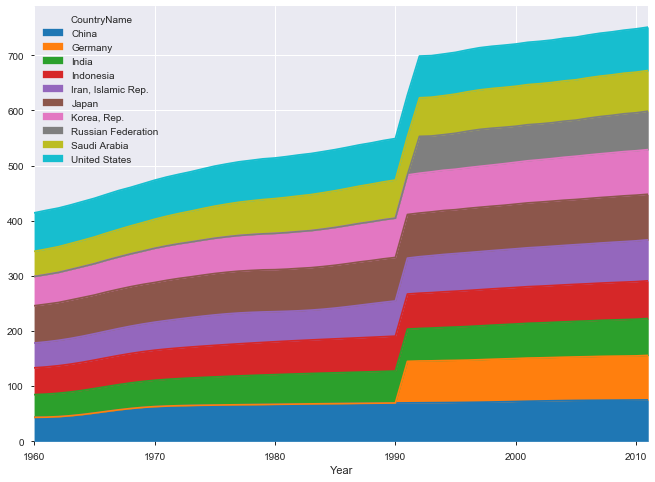

In [46]:
df_life_peor = df_10peores.groupby(['Year', 'CountryName'])['Life expectancy at birth, total (years)'].sum().unstack('CountryName').fillna(0)
df_life_peor.plot(kind='area', stacked=True, legend=True,figsize=(11,8))

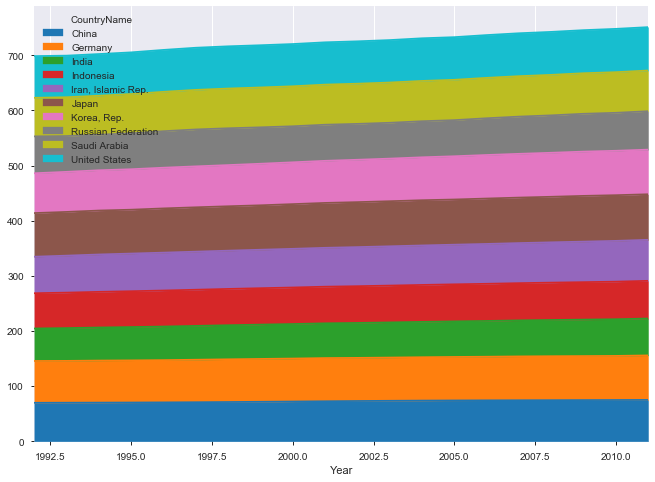

In [47]:
df_m =df_10peores2.groupby(['Year', 'CountryName'])['Life expectancy at birth, total (years)'].sum().unstack('CountryName').fillna(0)
df_m.plot(kind='area', stacked=True, legend=True,figsize=(11,8))

Tal vez no logramos hallar una correlación inicialmente porque estábamos estudiando todos los países en todos los años. Puede ser que el resultado cambie si estudiamos los 10 países con más emisiones de CO2 sólo en los últimos años:

In [48]:
sigloxxi=df_10peores[df_10peores['Year'].apply(lambda x: x>2000 and x<2011)]

In [49]:
pandas_profiling.ProfileReport(sigloxxi)

Nuevamente las correlaciones son positivas. Se concluye que no podemos hallar una correlación directa entre ambos indicadores (al menos directa) ya que la esperanza de vida depende de muchos factores muy complejos y muchos pesan más que el CO2, como por ejemplo la fertilidad, la mortalidad, población, etc. Es lógico no hallar lo que buscamos.

Tal vez el CO2 no tiene un gran impacto en la esperanza de vida por sí mismo, pero analizado con otras variables sí tenga algún efecto negativo. Tratemos de crear un modelo de predicción para esperanza de vida utilizando más variables esta vez.

# Modeling

Primero seleccionamos de la lista de indicadores todos los que parecen relevantes o que tienen alguna influencia sobre esperanza de vida, esos se encuentran en df_indicator_selection.

In [50]:
df_indicator_selection = pd.read_csv ('Indicator_selection.csv')

In [51]:
ind1 = list(df_indicator_selection['Indicators'])

In [52]:
ind1

['Fertilizer consumption (kilograms per hectare of arable land)',
 'Terrestrial and marine protected areas (% of total territorial area)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Rural population (% of total population)',
 'Urban population (% of total)',
 'Agricultural methane emissions (thousand metric tons of CO2 equivalent)',
 'Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Access to non-solid fuel (% of population)',
 'Access to non-solid fuel, rural (% of rural population)',
 'Access to non-solid fuel, urban (% of urban population)',
 'Annual freshwater withdrawals, total (% of internal resources)',
 'Total natural resources rents (% of GDP)',
 'Condom use, population ages 15-24, female (% of females ages 15-24)',
 'Condom use, population ages

In [53]:
ind2 = ['CountryName','Year','CO2 emissions (metric tons per capita)','Life expectancy at birth, total (years)', 'GDP per capita (constant 2005 US$)']

In [54]:
selection_ind = ind1 + ind2

In [55]:
df_model=df_paises[df_paises.columns.intersection(selection_ind)]

Ya tenemos el df para nuestro modelo, ahora hay que limpiarlo. Para que los datos sirvan para armar un modelo necesitamos filas que tengan todos los indicadores que consideremos, no podemos tener falta de datos.

In [56]:
df_model.head()

IndicatorName  CountryName  Year  Access to electricity (% of population)  \
0              Afghanistan  1960                                      NaN   
1              Afghanistan  1961                                      NaN   
2              Afghanistan  1962                                      NaN   
3              Afghanistan  1963                                      NaN   
4              Afghanistan  1964                                      NaN   

IndicatorName  Access to electricity, rural (% of rural population)  \
0                                                            NaN      
1                                                            NaN      
2                                                            NaN      
3                                                            NaN      
4                                                            NaN      

IndicatorName  Access to electricity, urban (% of urban population)  \
0                                                            NaN      
1                                                            NaN      
2                                                            NaN      
3                                                            NaN      
4                                                            NaN      

IndicatorName  Access to non-solid fuel (% of population)  \
0                                                     NaN   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4                                                     NaN   

IndicatorName  Access to non-solid fuel, rural (% of rural population)  \
0                                                            NaN         
1                                                            NaN         
2                                                            NaN         
3                                                            NaN         
4                                                            NaN         

IndicatorName  Access to non-solid fuel, urban (% of urban population)  \
0                                                            NaN         
1                                                            NaN         
2                                                            NaN         
3                                                            NaN         
4                                                            NaN         

IndicatorName  Agricultural methane emissions (thousand metric tons of CO2 equivalent)  \
0                                                            NaN                         
1                                                            NaN                         
2                                                            NaN                         
3                                                            NaN                         
4                                                            NaN                         

IndicatorName  Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)  \
0                                                            NaN                               
1                                                            NaN                               
2                                                            NaN                               
3                                                            NaN                               
4                                                            NaN                               

IndicatorName  ...  Pregnant women receiving prenatal care (%)  \
0              ...                                         NaN   
1              ...                                         NaN   
2              ...                                         NaN   
3              ...                          

In [57]:
df_model.shape

(10640, 44)

In [58]:
df_model.isna().sum()

IndicatorName
CountryName                                                                                                  0
Year                                                                                                         0
Access to electricity (% of population)                                                                   9880
Access to electricity, rural (% of rural population)                                                      9880
Access to electricity, urban (% of urban population)                                                      9880
Access to non-solid fuel (% of population)                                                                9884
Access to non-solid fuel, rural (% of rural population)                                                  10262
Access to non-solid fuel, urban (% of urban population)                                                  10262
Agricultural methane emissions (thousand metric tons of CO2 equivalent)                           

Vemos que hay indicadores con muchos NaNs, algunos están casi vacíos (10000+ nans en 10640 filas es que casi no tienen datos). De alguna manera hay que sacar los indicadores que tengan x número de NaNs.

Como me interesa que aparezcan las emisiones de CO2, probemos con que el número máximo de NaNs sea aproximadamente 3000. Osea que el número de non na values sería aproximadamente 7000.

In [59]:
df_model2=df_model.dropna(thresh=7000,axis=1)

In [60]:
df_model2.isna().sum()

IndicatorName
CountryName                                    0
Year                                           0
CO2 emissions (metric tons per capita)      2145
Fertility rate, total (births per woman)     894
GDP per capita (constant 2005 US$)          2634
Life expectancy at birth, total (years)      893
Number of infant deaths                     1287
Number of under-five deaths                 1287
Population, total                            223
Rural population (% of total population)     220
Urban population (% of total)                220
dtype: int64

In [61]:
df_model2=df_model2.dropna()

In [62]:
df_model2=df_model2.drop('CountryName',axis=1)

In [63]:
df_model2=df_model2.drop('Year',axis=1)

In [64]:
df_model2.shape

(6682, 9)

In [65]:
X = df_model2.drop('Life expectancy at birth, total (years)',axis=1)
y = df_model2['Life expectancy at birth, total (years)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
est = sm.OLS(y_train, X_train.astype(float)).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Life expectancy at birth, total (years)   R-squared:                       0.803
Model:                                                 OLS   Adj. R-squared:                  0.803
Method:                                      Least Squares   F-statistic:                     3113.
Date:                                     Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                                             17:39:53   Log-Likelihood:                -16106.
No. Observations:                                     5345   AIC:                         3.223e+04
Df Residuals:                                         5337   BIC:                         3.228e+04
Df Model:                                                7                                         
Covariance Type:                                 nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
CO2 emissions (metric tons per capita)      -0.0536      0.016     -3.391      0.001      -0.085      -0.023
Fertility rate, total (births per woman)    -3.5766      0.047    -75.317      0.000      -3.670      -3.484
GDP per capita (constant 2005 US$)           0.0001   8.27e-06     14.227      0.000       0.000       0.000
Number of infant deaths                    8.85e-05   6.18e-06     14.328      0.000    7.64e-05       0.000
Number of under-five deaths              -6.125e-05   4.13e-06    -14.838      0.000   -6.93e-05   -5.32e-05
Population, total                         -4.83e-09   9.76e-10     -4.947      0.000   -6.74e-09   -2.92e-09
Rural population (% of total population)     0.7303      0.003    209.204      0.000       0.724       0.737
Urban population (% of total)                0.8285      0.003    318.429      0.000       0.823       0.834
==============================================================================
Omnibus:                      581.477   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1297.757
Skew:                          -0.664   Prob(JB):                    1.57e-282
Kurtosis:                       5.016   Cond. No.                     9.18e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
predictions = est.predict(X_train)
mean_squared_error(y_train, predictions)

24.253006021828426

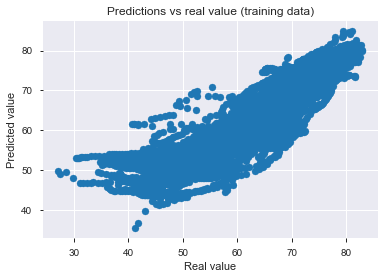

In [68]:
plt.scatter(y_train, predictions)
plt.title("Predictions vs real value (training data)")
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.show()

In [69]:
pred_test = est.predict(X_test)
mean_squared_error(y_test, pred_test)

25.540657080915175

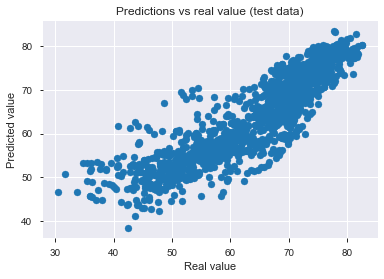

In [70]:
plt.scatter(y_test, pred_test)
plt.title("Predictions vs real value (test data)")
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.show()

Cabe destacar que el criterio para definir el número de NaNs admisibles es arbitriario, por lo tanto si cambia ese número cambia el modelo. Por ejemplo tomemos que el número de non na values que quiero sea 5000 en vez de 7000. Lo lógico será tener más indicadores porque el criterio es menos exigente, a su vez si tengo más indicadores (columnas) tendré menos filas en el modelo, ya que cuando dropeo los nans estoy imponiendo que toda fila que tenga un nan se vaya, es decir que cuantos más indicadores tenga en las columnas más difícil va a ser que no se dropee una fila, porque tendrá que tener más indicadores, y viceversa.

In [71]:
error=y_test-pred_test

In [72]:
len(error)

1337

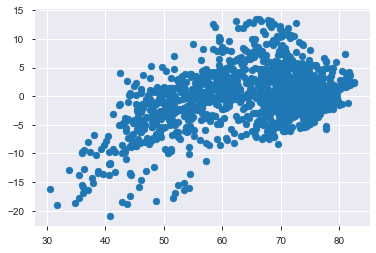

In [73]:
plt.scatter(y_test,error)

In [74]:
len(error[error.apply(lambda x: x>-8 and x<8)])

1196

1196 datos de 1337 tienen un error entre -8 y 8. Casi un 90%.

**Tratemos de crear un mejor modelo normalizando los datos**

Normalizar los datos es algo que se hace cuando se tienen distintas variables con distintos órdenes de magnitud. En este caso las emisiones de CO2 pueden estar entre 0 y varias decenas de millones cuando la esperanza de vida estara entre 0 y 80, por lo tanto normalizar puede mejorar la precisión del modelo.

In [75]:
X1=df_model2.drop('Life expectancy at birth, total (years)', axis=1)

In [76]:
normalized_data = preprocessing.normalize(X1)

In [77]:
X = normalized_data
y = df_model2['Life expectancy at birth, total (years)']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
est2 = sm.OLS(y_train1, X_train1.astype(float)).fit()

est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                           
============================================================================================================
Dep. Variable:     Life expectancy at birth, total (years)   R-squared (uncentered):                   0.996
Model:                                                 OLS   Adj. R-squared (uncentered):              0.996
Method:                                      Least Squares   F-statistic:                          1.766e+05
Date:                                     Fri, 08 Nov 2019   Prob (F-statistic):                        0.00
Time:                                             17:39:54   Log-Likelihood:                         -14969.
No. Observations:                                     5345   AIC:                                  2.995e+04
Df Residuals:                                         5337   BIC:                                  3.001e+04
Df Model:                                                8                                                  
Covariance Type:                                 nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3.725e+04   5846.104     -6.372      0.000   -4.87e+04   -2.58e+04
x2          2.294e+04   2.07e+04      1.109      0.267   -1.76e+04    6.35e+04
x3            49.7654      4.342     11.460      0.000      41.253      58.278
x4         -3613.6839    137.354    -26.309      0.000   -3882.955   -3344.413
x5          -653.2010     79.838     -8.182      0.000    -809.717    -496.685
x6            73.1931      0.085    862.113      0.000      73.027      73.360
x7         -6257.4837   1069.331     -5.852      0.000   -8353.808   -4161.159
x8          1952.6400   1481.447      1.318      0.188    -951.602    4856.882
==============================================================================
Omnibus:                      931.388   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5325.149
Skew:                          -0.710   Prob(JB):                         0.00
Kurtosis:                       7.679   Cond. No.                     3.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Al normalizar se pierden los nombres de las columnas del dataframe pasando a ser x1, x2, etc. El orden es el mismo que antes, es decir x1 es 'CO2 emissions (metric tons per capita)', x2 es 'Fertility rate, total (births per woman)' y así sucesivamente.

Es raro que el R2 de tan alto, puede que haya algo que no esté bien. Algo que puede estar pasando es que al dividir el dataset en train y test, queden datos de mismos paises en ambos, por eso es como que la predicción da excelente, cuando en realidad no es así. Un ejemplo es que si tengo datos en el train de uruguay en 1990 y 1992, puedo llegar a tener de uruguay en 1991 en el test y claramente va a predecir bien, pero no es un buen modelo. Hay que tratar de dividir los países aleatoriamente para ver si es ese el problema.

In [79]:
df_model3=df_model.dropna(thresh=7000,axis=1)

In [80]:
df_model3=df_model3.dropna()

In [81]:
paises=df_model3['CountryName'].unique()

Esta vez voy a dividir a mano los países con un random los datos en train y test, tomando aproximadamente 80% de los países para train y 20% para test. De manera que no me queden los mismos paises en ambos.

In [82]:
random.seed(42)
paises_train=random.sample(set(paises),int(0.8*len(paises)))

In [83]:
paises_test=df_model3[df_model3['CountryName'].apply(lambda x: x not in paises_train)]['CountryName'].unique()

In [84]:
df_model4=df_model3[df_model3['CountryName'].apply(lambda x: x in paises_train)]

In [85]:
df_model4=df_model4.drop('CountryName',axis=1)
df_model4=df_model4.drop('Year',axis=1)
X_train2=df_model4.drop('Life expectancy at birth, total (years)', axis=1)
y_train2=df_model4['Life expectancy at birth, total (years)']

In [86]:
df_model5=df_model3[df_model3['CountryName'].apply(lambda x: x in paises_test)]

In [87]:
df_model5=df_model5.drop('CountryName',axis=1)
df_model5=df_model5.drop('Year',axis=1)
X_test2=df_model5.drop('Life expectancy at birth, total (years)', axis=1)
y_test2=df_model5['Life expectancy at birth, total (years)']

In [88]:
X_train2norm = preprocessing.normalize(X_train2)

In [89]:
est2 = sm.OLS(y_train2, X_train2norm.astype(float)).fit()

est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                           
============================================================================================================
Dep. Variable:     Life expectancy at birth, total (years)   R-squared (uncentered):                   0.996
Model:                                                 OLS   Adj. R-squared (uncentered):              0.996
Method:                                      Least Squares   F-statistic:                          1.648e+05
Date:                                     Fri, 08 Nov 2019   Prob (F-statistic):                        0.00
Time:                                             17:39:55   Log-Likelihood:                         -14839.
No. Observations:                                     5261   AIC:                                  2.969e+04
Df Residuals:                                         5253   BIC:                                  2.975e+04
Df Model:                                                8                                                  
Covariance Type:                                 nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.117e+04   7913.764     -5.202      0.000   -5.67e+04   -2.57e+04
x2          3.787e+04   1.98e+04      1.917      0.055    -856.462    7.66e+04
x3            53.1298      4.310     12.327      0.000      44.680      61.579
x4         -3393.4292    131.481    -25.809      0.000   -3651.186   -3135.672
x5          -755.4232     74.844    -10.093      0.000    -902.148    -608.698
x6            73.0248      0.086    846.652      0.000      72.856      73.194
x7         -8900.7259   1079.527     -8.245      0.000    -1.1e+04   -6784.405
x8          3152.5175   1179.354      2.673      0.008     840.493    5464.542
==============================================================================
Omnibus:                     1031.793   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5863.435
Skew:                          -0.817   Prob(JB):                         0.00
Kurtosis:                       7.907   Cond. No.                     3.53e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

El R2 volvió a dar muy alto, lo que significa que el problema no era la división del data set. El R2 lo que refleja es qué proporción de la variabilidad puede ser explicada por el modelo, no necesariamente implica una alta calidad de modelo. Puede que sea alto porque estemos agregando demasiadas variables al modelo y eso genera "overfitting". A su vez, estamos trabajando con datos que son series de tiempo, por lo tanto los datos siguen tendencias con los años, esto puede también afectar el valor de R2. Deberíamos estudiar más a fondo para realmente saber por qué nos da ese valor tan elevado.

In [90]:
predictions2 = est2.predict(X_train2norm)
mean_squared_error(y_train2, predictions2)

16.50027550354286

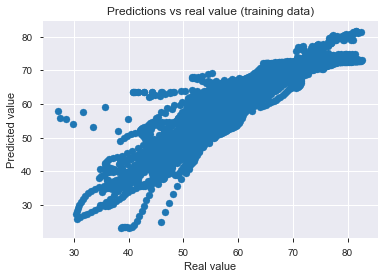

In [91]:
plt.scatter(y_train2, predictions2)
plt.title("Predictions vs real value (training data)")
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.show()

In [92]:
X_test2norm=preprocessing.normalize(X_test2)

In [93]:
pred_test2 = est2.predict(X_test2norm)
mean_squared_error(y_test2, pred_test2)

14.991937797778192

El error da bastante menor que en el anterior modelo.

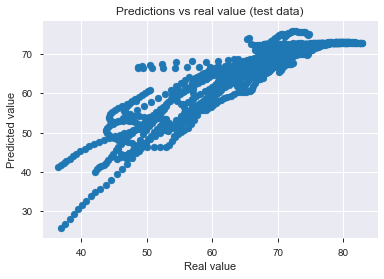

In [94]:
plt.scatter(y_test2, pred_test2)
plt.title("Predictions vs real value (test data)")
plt.xlabel("Real value")
plt.ylabel("Predicted value")
plt.show()

Se observa una forma similar a los datos train.

In [95]:
error2=y_test2-pred_test2

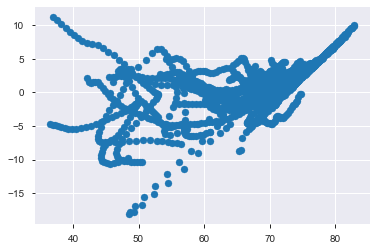

In [96]:
plt.scatter(y_test2,error2)

Este modelo tiene menor error que el anterior.

# Conclusiones
1. **No fue posible hallar una correlación directa entre emisiones de CO2 y esperanza de vida**, lo cual tiene sentido ya que la esperanza de vida es un valor muy complejo que depende de una cantidad muy grande de factores que pesan mucho más que el CO2, un ejemplo puede ser el desarrollo de un país, el acceso a la salud, la pobreza, las guerras, fertilidad, etc.
2. Si bien no fue posible hallar esa correlación, se logró crear un modelo logra predecir con un error razonable la esperanza de vida a partir de muchos factores junto con las emisiones de CO2. Es interesante concluir que **si bien no hay correlación del CO2 por sí sólo con la esperanza de vida, en el modelo tiene un coeficiente negativo es decir que tiene un impacto negativo en la esperanza de vida cuando se lo analiza junto con otros factores**.
3. No logramos explicar exactamente por qué tenemos un R2 tan alto en el último modelo, se debería analizar en profundidad por qué está pasando esto. Puede ser por alguno de los factores anteriormente mencionados, el hecho de tener datos que son series de tiempo por ejemplo. No tuvimos el tiempo necesario para analizarlo en profundidad.
4. Fue interesante para el equipo el hecho de aprender que muchas veces las correlaciones que uno busca encontrar no son tales y que hay que ser capaz de darse cuenta de eso a tiempo y cambiar el enfoque o la pregunta. Creemos que es una de las claves del trabajo de la ciencia de datos. En nuestro caso, no hayamos lo que inicialmente buscamos o por lo menos de la manera que queríamos, sino que tuvimos que analizar el problema utilizando más variables para tener una conclusión más acertada.